In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt

repo_dir = os.getcwd() + '/repo'
tft_dir = os.path.join(repo_dir, 'tft')
os.chdir(tft_dir)

import warnings  
warnings.filterwarnings('ignore')

In [2]:
output_folder = os.path.join(os.getcwd(), 'outputs_carriage_services_w_open')   # Root folder to save experiment outputs
force_download = False 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
df = pd.read_csv('carriage_services.csv', parse_dates = True, index_col=0)
df.drop(df[df['Volume']==0].index, inplace = True)

In [3]:
days = list()
months = list()
years = list()
for d in df.index:
    days.append(int(str(d)[8:10]))
df['days'] = list(range(1, len(df) + 1))
df['day_of_month'] = days
df['id'] = 0
df['categorical_id'] = 0
df['date'] = df.index
df.head()

Open    High     Low   Close  Adj Close   Volume  days  \
Date                                                                   
1996-08-09  14.250  16.750  14.250  16.500  14.892752  1601500     1   
1996-08-12  16.500  16.750  16.375  16.500  14.892752   260900     2   
1996-08-13  16.500  16.750  16.375  16.375  14.779927   162800     3   
1996-08-14  16.375  16.625  16.375  16.375  14.779927    59500     4   
1996-08-15  16.625  16.625  16.375  16.625  15.005575    62300     5   

            day_of_month  id  categorical_id       date  
Date                                                     
1996-08-09             9   0               0 1996-08-09  
1996-08-12            12   0               0 1996-08-12  
1996-08-13            13   0               0 1996-08-13  
1996-08-14            14   0               0 1996-08-14  
1996-08-15            15   0               0 1996-08-15

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6205 entries, 1996-08-09 to 2021-04-08
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Open            6205 non-null   float64       
 1   High            6205 non-null   float64       
 2   Low             6205 non-null   float64       
 3   Close           6205 non-null   float64       
 4   Adj Close       6205 non-null   float64       
 5   Volume          6205 non-null   int64         
 6   days            6205 non-null   int64         
 7   day_of_month    6205 non-null   int64         
 8   id              6205 non-null   int64         
 9   categorical_id  6205 non-null   int64         
 10  date            6205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 581.7 KB


In [5]:
from data_formatters.base import GenericDataFormatter, DataTypes, InputTypes

# View avialable inputs and data types.
print("Available data types:")
for option in DataTypes:
    print(option)

print()
print("Avaialbe input types:")
for option in InputTypes:
    print(option)

Available data types:
DataTypes.REAL_VALUED
DataTypes.CATEGORICAL
DataTypes.DATE

Avaialbe input types:
InputTypes.TARGET
InputTypes.OBSERVED_INPUT
InputTypes.KNOWN_INPUT
InputTypes.STATIC_INPUT
InputTypes.ID
InputTypes.TIME


In [6]:
from libs import utils 
import sklearn.preprocessing
class StockFormatter(GenericDataFormatter):
    _column_definition = [
        ('id', DataTypes.REAL_VALUED, InputTypes.ID),
        ('days', DataTypes.REAL_VALUED, InputTypes.TIME),
        ('day_of_month', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('Open', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('High', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Low', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Close', DataTypes.REAL_VALUED, InputTypes.TARGET),
        ('Volume', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT)
    ]
    
    def __init__(self):
        """initializes formatter"""
        
        self.identifiers = None
        self._real_scalers = None
        self._cat_scalers = None
        self._target_scaler = None
        self._num_classes_per_cat_input = None
    
    def split_data(self, data):
        """
        split data frame into training-validation-test data frames
        
        """
        print('Formatting train-valid-test splits.')
        
        train_start = dt.date(1996,8,9)
        train_end = dt.date(2011,12,31)
        train_data = data.loc[train_start:train_end]

        val_start = dt.date(2012,1,1)
        val_end = dt.date(2016,12,31)
        val_data = data.loc[val_start:val_end]

        test_start = dt.date(2016,1,1)
        test_end = dt.date(2020,4,7)
        test_data = data.loc[test_start:test_end]
        
        self.set_scalers(train_data)
        
        return (self.transform_inputs(data) for data in [train_data, val_data, test_data])
    
    def set_scalers(self, df):
        """
        Calibrates scalers using the data supplied.
        (제공된 데이터를 사용해서 scaler 교정)

        Args:
          df: Data to use to calibrate scalers.
        """
        print('Setting scalers with training data...')
        
        column_definitions = self.get_column_definition()

        id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)
        # extract identifiers in case required
#         stock에는 identifier가 현재 따로 필요해보이지 않음(데이터 entity가 한개이기 때문)
#         self.identifiers = list(df[id_column].unique())
        
        # Format real scalers
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        data = df[real_inputs].values
        self._real_scalers = sklearn.preprocessing.StandardScaler().fit(data)
        
        # target데이터를 prediction에 사용
        self._target_scaler = sklearn.preprocessing.StandardScaler().fit(df[[target_column]].values)
        
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        categorical_scalers = {}
        num_classes = []
        for col in categorical_inputs:
            srs = df[col].apply(str)
            categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(srs.values)
            num_classes.append(srs.nunique())
        
        # set categorical scaler outputs
        self._cat_scalers = categorical_scalers
        self._num_classes_per_cat_input = num_classes
        
    def transform_inputs(self, df):
        """
        performs feature transformations.
        
        feature engineering, preprocessing and normalization을 포함
        
        Args:
            df - data frame to transform.
            
        Returns:
            Transformed data frame.
        """
        output = df.copy()
        
        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')
        
        column_definitions = self.get_column_definition()
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME}
        )
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        output[real_inputs] = self._real_scalers.transform(df[real_inputs].values)
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)
        return output
    
    def format_predictions(self, predictions):
        output = predictions.copy()
        
        column_names = predictions.columns
        for col in column_names:
            if col not in {'forecast_time', 'identifier'}:
                output[col] = self._target_scaler.inverse_transform(predictions[col])
                
        return output
    
    def get_fixed_params(self):
        fixed_params = {
            'total_time_steps': 51,     # Total width of the Temporal Fusion Decoder
            'num_encoder_steps': 50,    # Length of LSTM decoder (ie. # historical inputs)
            'num_epochs': 100,            # Max number of epochs for training
            'early_stopping_patience': 5, # Early stopping threshold for # iterations with no loss improvement
            'multiprocessing_workers': 5  # Number of multi-processing workers
        }
        
        return fixed_params
    
    def get_default_model_params(self):
        model_params = {
            'dropout_rate': 0.3,
            'hidden_layer_size': 160,
            'learning_rate': 0.01,
            'minibatch_size': 64,
            'max_gradient_norm': 0.01,
            'num_heads': 1,
            'stack_size': 1
        }

        return model_params

In [7]:
data_formatter = StockFormatter()
train, valid, test = data_formatter.split_data(df)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

Formatting train-valid-test splits.
Setting scalers with training data...


In [8]:
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as util

ModelClass = libs.tft_model.TemporalFusionTransformer
data_params = data_formatter.get_experiment_params()
param_ranges = ModelClass.get_hyperparm_choices()

In [9]:
model_params = {'dropout_rate': 0.3,      # Dropout discard rate
                'hidden_layer_size': 320, # Internal state size of TFT
                'learning_rate': 0.0001,   # ADAM initial learning rate
                'minibatch_size': 512,    # Minibatch size for training
                'max_gradient_norm': 100.,# Max norm for gradient clipping
                'num_heads': 4,           # Number of heads for multi-head attention
                'stack_size': 1           # Number of stacks (default 1 for interpretability)
               }

In [10]:
model_folder = os.path.join(output_folder, 'saved_models', 'carriage_services_w_open', 'fixed')
model_params['model_folder'] = model_folder

model_params.update(data_params)

In [11]:
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager(param_ranges, data_params, model_folder)

*** Loading hyperparm manager ***


In [12]:
success = opt_manager.load_results()
restart_opt = None
if success and not restart_opt:
    print("Loaded results from previous training")
else:
    print("Creating new hyperparameter optimisation")
    opt_manager.clear()

Loading results from /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed
Loaded results from previous training


In [13]:
import tensorflow as tf
from libs.tft_model import TemporalFusionTransformer

# Specify GPU usage
tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=2)

Selecting GPU ID=2


In [16]:
tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:

    tf.compat.v1.keras.backend.set_session(sess)
    params = opt_manager.get_next_parameters()
    # Create a TFT model
    model = TemporalFusionTransformer(model_params,
                                    use_cudnn=True) # Run model on GPU using CuDNNLSTM cells

    # Sample data into minibatches for training
    if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)

    # Train and save model
    model.fit()
    
    val_loss = model.evaluate()
    if np.allclose(val_loss, 0.) or np.isnan(val_loss):
        # Set all invalid losses to infintiy.
        # N.b. val_loss only becomes 0. when the weights are nan.
        print("Skipping bad configuration....")
        val_loss = np.inf
    opt_manager.update_score(params, val_loss, model)
    tf.compat.v1.keras.backend.set_session(sess)
    model.save(model_folder)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.0001
# minibatch_size = 512
# max_gradient_norm = 100.0
# num_heads = 4
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed
# total_time_steps = 51
# num_encoder_steps = 50
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('days', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('day_of_month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('Open

Cached data "train" updated
Cached data "valid" updated
*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 3824 samples, validate on 1208 samples
Epoch 1/100
3824/3824 [==============================] - ETA: 0s - loss: 0.9960WARNING:tensorflow:From /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
3824/3824 [==============================] - 7s 2ms/sample - loss: 0.9960 - val_loss: 0.8217
Epoch 2/100
3824/3824 [==============================] - 3s 800us/sample - loss: 0.5609 - val_loss: 0.6352
Epoch 3/100
3824/3824 [==============================] - 3s 798us/sample - loss: 0.4665 - val_loss: 0.5382
Epoch 4/100


In [20]:
test.head()

Open      High       Low     Close  Adj Close    Volume  days  \
Date                                                                            
2016-01-04  2.432446  2.383335  2.390157  2.368078  22.039961  0.698294  4881   
2016-01-05  2.366486  2.346963  2.363743  2.377283  22.096394  1.246038  4882   
2016-01-06  2.340408  2.322715  2.379281  2.358874  21.983515  0.092742  4883   
2016-01-07  2.295923  2.286342  2.284500  2.274498  21.466143  0.443933  4884   
2016-01-08  2.288253  2.271187  2.262747  2.239214  21.249790  1.100069  4885   

            day_of_month  id  categorical_id       date  
Date                                                     
2016-01-04     -1.342525   0               0 2016-01-04  
2016-01-05     -1.228271   0               0 2016-01-05  
2016-01-06     -1.114017   0               0 2016-01-06  
2016-01-07     -0.999764   0               0 2016-01-07  
2016-01-08     -0.885510   0               0 2016-01-08

In [14]:
tf.compat.v1.reset_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    model.load(model_folder)
    
    # Make forecasts
    output_map = model.predict(test, return_targets=True)
    
    targets = data_formatter.format_predictions(output_map["targets"])
    # Format predictions
    
    p50_forecast = data_formatter.format_predictions(output_map["p50"])
    p90_forecast = data_formatter.format_predictions(output_map["p90"])

    def extract_numerical_data(data):
        """Strips out forecast time and identifier columns."""
        return data[[
            col for col in data.columns
            if col not in {"forecast_time", "identifier"}
        ]]
    # Compute Losses
    p50_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p50_forecast),
        0.5)
    p90_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p90_forecast),
        0.9)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.0001
# minibatch_size = 512
# max_gradient_norm = 100.0
# num_heads = 4
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed
# total_time_steps = 51
# num_encoder_steps = 50
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('days', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('day_of_month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('Open


Loading model from /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/dense_10/bias (float32) [1]
[0.]
tensor: TemporalFusionTransformer/dense_10/kernel (float32) [320, 1]
[[-0.0521136 ]
 [-0.060717  ]
 [-0.05771583]
 [ 0.08278665]
 [ 0.13495348]
 [-0.12005969]
 [ 0.06504281]
 [ 0.03157681]
 [ 0.07217278]
 [-0.09058754]
 [-0.01778335]
 [-0.08627631]
 [-0.02226923]
 [-0.01370401]
 [-0.01263408]
 [-0.08888994]
 [-0.13097961]
 [ 0.08237614]
 [-0.12446979]
 [-0.06254716]
 [-0.08684886]
 [ 0.10495889]
 [-0.094049  ]
 [-0.08749178]
 [ 0.09902966]
 [-0.02500013]
 [ 0.11613865]
 [-0.09945591]
 [-0.11487841]
 [ 0.05673811]
 [-0.11180686]
 [ 0.07301694]
 [-0.06218717]
 [ 0.13160615]
 [-0.04923099]
 [-0.01138721]
 [ 0.01317394]
 [ 0.07499897]
 [-0.10226633]
 [-0.04954831]
 [-0.09639985]
 [-0.03279667]
 [ 0.1167006 ]
 [-0.13533229]
 [ 0.01321723]
 [-0.04728429]
 [-0.13656715]

  1.22690818e-03 -8.14350322e-04  9.33161718e-05  2.04899901e-04]
tensor: TemporalFusionTransformer/layer_normalization_15/gamma (float32) [320]
[1.0002668  0.99968624 1.0026144  1.001033   0.9982765  0.99785674
 0.99911374 0.99969035 1.0004307  1.001513   1.0012141  0.997943
 0.99868363 1.0007602  1.0004991  1.0029663  1.0021479  1.0002937
 1.0006013  1.0028965  0.999179   1.0013723  1.0009795  1.0003482
 0.99765235 1.0046759  0.99757504 0.99790204 1.0012745  1.0003662
 0.9984285  1.0011982  0.9992176  1.0014521  0.995051   1.0004902
 1.0010264  1.0025736  1.0002495  1.0030289  0.998962   1.0020397
 1.0011991  1.0018612  0.99945563 0.9983638  1.0012901  0.99996173
 0.9988463  1.0035281  1.0010062  1.0003675  0.99720365 1.0059179
 0.99913454 1.0017756  0.99911714 1.0006725  1.0032415  1.0015607
 1.0061277  1.0004619  0.9961688  1.0024571  1.0023035  1.0031247
 0.9993548  1.0019901  1.0022615  1.000106   0.9990579  1.0025662
 0.9992157  0.9987617  1.0000917  1.000654   1.0007912  1.0006

[[-0.00101478 -0.0958842  -0.01752963 ...  0.02546033  0.08545136
   0.05974702]
 [-0.05952505  0.08129559 -0.05942914 ... -0.07896191 -0.03558518
   0.03527913]
 [-0.04774883 -0.08720929 -0.05855164 ... -0.05091083 -0.02912613
   0.01533576]
 ...
 [-0.00230738  0.05172307  0.08462439 ... -0.06795422 -0.09297808
   0.01571811]
 [ 0.08899066 -0.0896358  -0.0240996  ... -0.00272961  0.03820654
   0.08042217]
 [-0.01154216 -0.01247497 -0.03822916 ... -0.00764978  0.03023066
  -0.06484525]]
tensor: TemporalFusionTransformer/time_distributed_29/bias (float32) [320]
[-2.00970695e-04 -1.23255260e-04 -1.08228982e-04  2.04122392e-03
 -6.39568141e-04  1.61365338e-03  5.43963513e-04  6.42913277e-04
  1.47861138e-03 -1.52669020e-03  4.60544601e-04  8.95498204e-04
  3.14375473e-04  1.77517312e-03 -1.88249117e-03  3.03894893e-04
  1.28613203e-04  9.24475258e-04  1.02379988e-03 -5.27790224e-04
 -7.39403593e-04  1.62104529e-03 -9.58706893e-04  1.25525490e-04
  6.83633785e-04  9.13495081e-04 -2.4856129

  4.29368578e-04 -1.82529271e-04 -4.44276346e-04  4.23526391e-04]
tensor: TemporalFusionTransformer/time_distributed_59/kernel (float32) [320, 320]
[[ 0.02051978 -0.02327717 -0.0608576  ... -0.03913685 -0.07493564
  -0.09057689]
 [-0.08068425  0.01462171 -0.04704797 ...  0.08331138  0.05087395
   0.05013713]
 [ 0.06922697  0.09632888 -0.05697414 ...  0.02000808  0.05963445
  -0.01153562]
 ...
 [-0.05717757  0.06371385  0.06510635 ...  0.05068506  0.00165399
   0.08186855]
 [ 0.02823325 -0.06811906 -0.05295841 ...  0.01012328 -0.04393287
  -0.06759   ]
 [-0.01046623  0.04610904  0.08972786 ... -0.04308445 -0.08194525
   0.01375827]]
tensor: TemporalFusionTransformer/time_distributed_6/bias (float32) [6]
[-0.00080995 -0.00102757 -0.00013448  0.00068302  0.00056886  0.00166854]
tensor: TemporalFusionTransformer/time_distributed_6/kernel (float32) [1920, 6]
[[-0.00893655 -0.0196637   0.0470548  -0.05609685 -0.03080979 -0.02687802]
 [-0.01671802  0.03351343 -0.04844764 -0.04181952 -0.019800

INFO:tensorflow:Restoring parameters from /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed/TemporalFusionTransformer.ckpt
Done.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [18]:
import datetime as dte
print("Hyperparam optimisation completed @ {}".format(dte.datetime.now()))
print("Best validation loss = {}".format(val_loss))
print("Params:")

# for k in best_params:
#     print(k, " = ", best_params[k])
#     print()
print("Normalised quantile losses: P50={}, P90={}".format(p50_loss.mean(), p90_loss.mean()))

Hyperparam optimisation completed @ 2021-04-28 06:44:53.401668
Best validation loss = 0.17463315934534893
Params:
Normalised quantile losses: P50=0.05755542183504214, P90=0.02103259627449504


<function matplotlib.pyplot.show(close=None, block=None)>

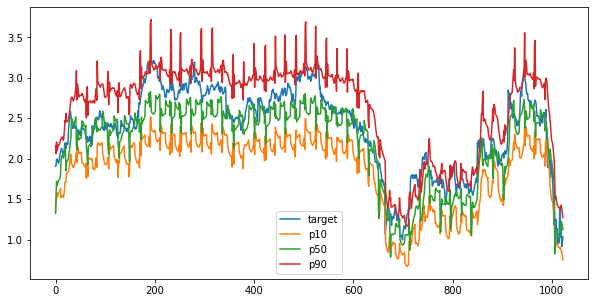

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(output_map['targets']['t+0'], label='target')
plt.plot(output_map['p10']['t+0'], label='p10')
plt.plot(output_map['p50']['t+0'], label='p50')
plt.plot(output_map['p90']['t+0'], label='p90')
plt.legend()
plt.show

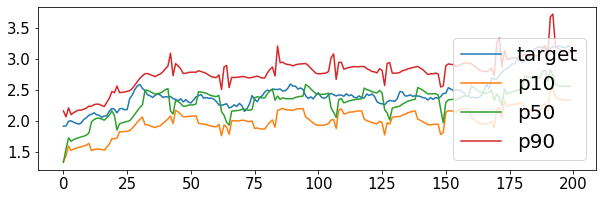

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(output_map['targets']['t+0'][:200], label='target')
plt.plot(output_map['p10']['t+0'][:200], label='p10')
plt.plot(output_map['p50']['t+0'][:200], label='p50')
plt.plot(output_map['p90']['t+0'][:200], label='p90')
plt.legend(loc='lower right', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

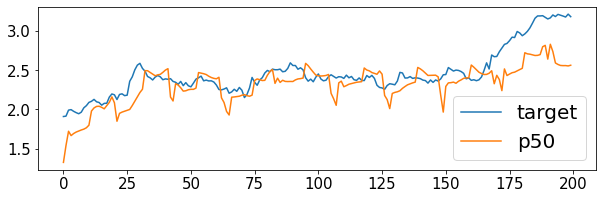

In [19]:
plt.figure(figsize=(10, 3))
plt.plot(output_map['targets']['t+0'][:200], label='target')
plt.plot(output_map['p50']['t+0'][:200], label='p50')
plt.legend(loc='lower right', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [22]:
# Store outputs in maps
counts = 0
interpretability_weights = {k: None for k in ['decoder_self_attn',
                                              'static_flags', 'historical_flags', 'future_flags']}

tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    
    tf.compat.v1.keras.backend.set_session(sess)
    
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    
    model.load(model_folder)
    for identifier, sliced in test.groupby('id'):
        
        print("Getting attention weights for {}".format(identifier))
        weights = model.get_attention(sliced)
        
        for k in interpretability_weights:
            w = weights[k]
            
            # Average attentin across heads if necessary
            if k == 'decoder_self_attn':
                w = w.mean(axis=0)
                
                # Store a single matrix for weights to reduce memory footprint
                batch_size, _, _ = w.shape
                counts += batch_size
            
            if interpretability_weights[k] is None:
                interpretability_weights[k] = w.sum(axis=0)
            else:
                interpretability_weights[k] += w.sum(axis=0)
                
interpretability_weight = {k: interpretability_weights[k]/counts for k in interpretability_weights}

print('Done.')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.0001
# minibatch_size = 512
# max_gradient_norm = 100.0
# num_heads = 4
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed
# total_time_steps = 51
# num_encoder_steps = 50
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('days', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('day_of_month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('Open

dense_79 (Dense)                (None, 51, 80)       25600       layer_normalization_16[0][0]     
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 51, 80)       25600       layer_normalization_16[0][0]     
__________________________________________________________________________________________________
tf_op_layer_TemporalFusionTrans [(None, None, None)] 0           tf_op_layer_TemporalFusionTransfo
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 51, 80)       25600       layer_normalization_16[0][0]     
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 51, 80)       25600       layer_normalization_16[0][0]     
__________________________________________________________________________________________________
dense_83 (

Loading model from /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/dense_10/bias (float32) [1]
[0.]
tensor: TemporalFusionTransformer/dense_10/kernel (float32) [320, 1]
[[-0.0521136 ]
 [-0.060717  ]
 [-0.05771583]
 [ 0.08278665]
 [ 0.13495348]
 [-0.12005969]
 [ 0.06504281]
 [ 0.03157681]
 [ 0.07217278]
 [-0.09058754]
 [-0.01778335]
 [-0.08627631]
 [-0.02226923]
 [-0.01370401]
 [-0.01263408]
 [-0.08888994]
 [-0.13097961]
 [ 0.08237614]
 [-0.12446979]
 [-0.06254716]
 [-0.08684886]
 [ 0.10495889]
 [-0.094049  ]
 [-0.08749178]
 [ 0.09902966]
 [-0.02500013]
 [ 0.11613865]
 [-0.09945591]
 [-0.11487841]
 [ 0.05673811]
 [-0.11180686]
 [ 0.07301694]
 [-0.06218717]
 [ 0.13160615]
 [-0.04923099]
 [-0.01138721]
 [ 0.01317394]
 [ 0.07499897]
 [-0.10226633]
 [-0.04954831]
 [-0.09639985]
 [-0.03279667]
 [ 0.1167006 ]
 [-0.13533229]
 [ 0.01321723]
 [-0.04728429]
 [-0.13656715]


[[-0.05908212  0.08442716  0.0648455  ... -0.03293822  0.08532697
   0.07680906]
 [-0.09519958 -0.06926813  0.04793499 ... -0.07263914  0.06116379
   0.01889534]
 [-0.0285644   0.02272283  0.03257475 ... -0.02758405 -0.06141251
  -0.03270052]
 ...
 [-0.07637064  0.08725541  0.06931264 ...  0.02068891 -0.02925786
   0.03479187]
 [ 0.0101357  -0.06172212  0.0086856  ...  0.08678853  0.05157785
   0.07710909]
 [ 0.08070675  0.02633234  0.081701   ... -0.07228884  0.03069634
  -0.02026492]]
tensor: TemporalFusionTransformer/dense_17/bias (float32) [320]
[ 4.19481876e-05  7.15874834e-04  6.23710366e-05 -3.01727094e-04
  4.32402740e-04 -7.99416099e-04 -3.27886839e-04  1.96791464e-03
  1.80127716e-03 -1.44962629e-04 -8.57525738e-04  2.32565406e-04
  1.50683697e-03 -5.94480836e-04  8.64185626e-04 -6.88412518e-04
 -1.04173750e-03  8.31139449e-04 -6.79119956e-04  4.84342832e-04
  6.08472419e-06  2.00757757e-03 -6.61807077e-04  5.28887613e-04
 -1.30321586e-03  1.16310839e-03  1.13784254e-03  1.51

[-3.54742137e-04 -2.12122966e-03 -6.43178180e-04 -3.81625630e-03
  3.49753653e-04 -7.86830031e-04  1.13202527e-03  2.71910132e-04
  3.20737227e-03 -5.15925640e-04 -1.13315147e-03 -1.58672652e-03
  4.23741119e-04 -1.62157672e-03  3.07161652e-04  2.13556015e-03
  3.03526089e-04 -1.00057269e-03  3.18896584e-03  4.69267456e-04
 -1.09257456e-03 -1.14256924e-03 -2.25646794e-03 -3.02918907e-03
 -3.08160525e-04 -1.38521020e-03 -1.13478501e-03  1.89021928e-03
 -7.67519407e-04 -3.83957755e-04 -1.14579080e-03  2.20326916e-03
 -5.09511119e-05  2.15623295e-03  1.11223235e-04 -4.12114343e-04
 -7.84855511e-04  6.46164059e-04 -7.93493964e-05  8.04259500e-04
 -2.80856068e-04  1.84221670e-03  5.75566373e-04 -2.21957598e-04
  3.13329790e-03  4.44333942e-04 -6.58020726e-04  4.15304303e-03
  1.32289820e-03 -2.40470472e-04 -4.45575919e-04  2.90865049e-04
  4.78482689e-04  2.61904090e-03 -1.47906691e-03 -1.55698403e-03
  6.22928608e-04  9.03559616e-04  2.35182513e-03  3.95185110e-04
 -1.28924393e-03 -8.83218

[0.]
tensor: TemporalFusionTransformer/dense_6/kernel (float32) [320, 1]
[[ 0.06872918]
 [-0.00394049]
 [-0.04968514]
 [-0.11095194]
 [ 0.08370344]
 [ 0.05437632]
 [-0.13298956]
 [-0.07328651]
 [-0.06696284]
 [-0.10694046]
 [ 0.02604698]
 [-0.1326412 ]
 [-0.1316949 ]
 [ 0.13066201]
 [ 0.1328152 ]
 [-0.05455679]
 [ 0.11373986]
 [-0.05729098]
 [-0.10724565]
 [-0.09368168]
 [ 0.10550705]
 [ 0.01278239]
 [ 0.0663943 ]
 [-0.07199806]
 [ 0.11959799]
 [-0.12556456]
 [-0.00052486]
 [ 0.07820037]
 [-0.07564854]
 [ 0.07935438]
 [-0.08244251]
 [ 0.11122356]
 [ 0.11614735]
 [ 0.02053045]
 [-0.05337269]
 [ 0.10026526]
 [ 0.05541714]
 [-0.07212652]
 [ 0.02269813]
 [-0.0580384 ]
 [ 0.04564749]
 [-0.08757588]
 [-0.03186052]
 [ 0.10385036]
 [-0.01050292]
 [-0.07286589]
 [ 0.1099959 ]
 [-0.01576205]
 [-0.00390698]
 [ 0.08259353]
 [-0.08638048]
 [ 0.03841269]
 [ 0.12682714]
 [ 0.07127084]
 [-0.03557639]
 [-0.07987805]
 [ 0.02791491]
 [-0.0644008 ]
 [-0.03126819]
 [ 0.07596576]
 [ 0.05470797]
 [ 0.0953921

[[-4.26755920e-02 -4.22841609e-02 -2.80313268e-02 -5.12623740e-03
   1.28216678e-02 -2.90026832e-02 -1.80956759e-02  1.27346134e-02
  -4.06184886e-03  2.29593311e-02  2.61833202e-02  3.70021164e-02
  -1.52880959e-02 -2.32625157e-02 -4.34322916e-02 -5.84484031e-03
  -8.86307284e-03  4.56289388e-02  9.74155776e-03 -1.21956598e-02
   1.72905084e-02 -2.44970191e-02  9.69914533e-03 -1.59679037e-02
   3.19287069e-02 -5.18464483e-03 -4.58290353e-02  2.81679947e-02
   3.76620330e-03  1.01573681e-02  1.86556894e-02  3.31362821e-02
  -9.34088510e-03  2.64357198e-02  1.49814300e-02  1.18838716e-02
  -3.85906175e-02 -7.57523376e-05 -3.18357795e-02 -3.93892117e-02
   3.51205952e-02 -1.13086507e-03  5.18055540e-03 -2.62669707e-03
  -2.81866975e-02 -3.51038054e-02  5.29219117e-03  1.25994841e-02
   2.32397206e-02  1.91309322e-02  4.75457795e-02  4.04774584e-02
   1.67361554e-02 -9.45487001e-04  1.18341967e-02 -4.65215631e-02
   4.60811295e-02 -6.89803902e-03  3.28655951e-02  2.31077746e-02
  -4.57069

[ 1.28530475e-04 -2.71895871e-04 -6.49440335e-05  1.98617508e-03
  1.23722747e-03  9.55738826e-04  8.87877773e-04 -2.57089222e-03
 -1.11654680e-03  2.13108331e-04 -1.35856199e-05  1.08671677e-03
  1.09212939e-03  1.41696219e-04  1.46395888e-03  6.32938638e-04
  1.78646110e-03 -8.88944021e-04  7.82906936e-05 -1.12699647e-03
  7.67412363e-04  4.72674350e-04  3.91593465e-04 -7.30443804e-04
 -5.94538651e-05 -3.06538248e-04  1.75913807e-03  2.16471250e-04
 -5.63981303e-04  5.77813305e-04  6.32545707e-05 -3.37661186e-04
 -2.43780305e-04 -3.72642156e-04  6.66394189e-04  1.06754410e-03
  6.99958298e-04 -1.36453207e-04  6.55862968e-04 -2.44169263e-03
  3.46432644e-04 -1.07558374e-03  5.85386006e-04 -6.37600664e-04
 -6.51570212e-04 -1.34430142e-04 -9.75760981e-04  1.43045932e-03
 -4.71345062e-04  1.86805584e-04 -1.24307990e-03 -6.86151208e-04
  5.16762491e-04  7.44457066e-05 -3.51946161e-04 -4.18538075e-05
  1.94873108e-04 -1.28446391e-03  1.02146668e-03 -1.62439956e-03
 -2.35681655e-03  3.97057

[ 1.26185443e-03  2.06939317e-03  1.97745598e-04 -1.51715343e-04
  2.54457438e-04 -5.05129283e-04 -1.43655474e-04  1.29879720e-03
  1.40588405e-03 -1.83024546e-04 -4.81191324e-04  4.89988364e-04
  1.72501488e-03  4.85180091e-04  7.86320132e-04 -5.84224821e-04
 -9.24503664e-04  7.88225327e-04 -5.51205943e-04  5.31493162e-04
 -7.32367989e-05  1.79779797e-03 -2.68039061e-04  6.69360918e-04
 -1.05666707e-03  1.05508708e-03  1.02153351e-03  8.75718019e-04
 -1.39300851e-03  1.69061229e-03 -3.24392720e-04 -7.42340810e-04
 -5.48161159e-04  4.77598747e-04  7.22725890e-05  6.69816916e-04
  4.86575998e-04  9.10380622e-04  9.31879040e-04  5.81325206e-04
 -3.54833028e-04 -4.33318928e-04 -8.91438220e-04  3.41362611e-04
  1.17062987e-03  6.53491821e-04 -7.45112891e-04  5.18310932e-04
 -7.56184978e-04 -6.37574005e-04 -6.04613742e-04 -2.24869218e-05
  2.24806645e-04 -8.66592920e-04 -7.94293883e-04 -8.60998640e-04
 -5.15835010e-04 -1.16840436e-03 -2.75701401e-04  1.58519761e-04
  4.26091428e-04 -9.37037

[-1.08381454e-03  1.22501550e-03  1.27729709e-05 -4.85647070e-05
  2.73057260e-04  4.65378573e-04  2.38806987e-03 -1.80194597e-03
 -1.72530454e-05 -1.63313665e-03 -9.55380907e-04  5.66647330e-04
 -1.40067088e-04  6.66938722e-04  2.93514895e-04 -2.36758686e-04
 -1.04276487e-03  8.67644092e-04 -2.70172884e-03 -2.63868691e-03
 -6.12327713e-04  1.47277140e-03 -4.35079157e-04  3.57408222e-04
 -8.60415050e-04  2.20870436e-03  4.96113033e-04 -2.62961513e-03
  3.28824949e-03  6.78541779e-04  1.16500654e-04  4.26857499e-04
  3.64863430e-04  3.98021541e-04 -2.34173218e-04  7.12039473e-04
 -2.63131340e-04  2.39251138e-04  2.13220227e-03  2.42611184e-03
  2.93063186e-03  6.65595871e-04  5.02358133e-04 -2.74239620e-03
 -1.19233853e-03 -5.12246974e-04  1.95528497e-03  6.82357932e-04
 -4.21055651e-04  1.06661778e-03 -1.28723530e-03 -2.12722621e-03
  3.19281535e-04  8.79487896e-04 -5.93045319e-04  1.92622351e-03
  8.30155623e-04  2.86750775e-03  7.35340582e-04 -1.96424266e-03
 -6.62884486e-05  1.80670

[-2.29680780e-04  3.78998788e-03  1.01122819e-03  1.19324413e-03
  6.26246631e-03 -7.95538537e-04  1.62594614e-03 -7.23435683e-03
 -1.17988442e-03  7.10085791e-04 -4.83731693e-03 -3.19332862e-03
 -1.55264349e-03  3.59964161e-03  2.95269443e-03 -4.82162368e-03
 -2.16681452e-04  4.69436543e-03 -5.56645775e-03 -4.94935503e-03
 -2.61991844e-03  2.24150857e-03 -5.45121031e-04  3.38516920e-03
 -5.61190944e-04  7.21777463e-03 -5.04568103e-04 -6.00503804e-03
  5.97888231e-03  1.52818311e-03  2.33407656e-04 -3.70529783e-03
 -2.81447032e-03 -1.12421205e-03 -1.62063260e-03 -1.09000935e-03
  3.39623285e-03  3.96854244e-03  4.81458101e-03  3.72186606e-03
  6.12885831e-03  1.56925491e-03 -8.65617942e-04 -1.91871182e-03
 -2.68984912e-03  1.25993416e-03  2.65026488e-03  4.66396974e-04
 -1.43376656e-03  2.33598845e-03  6.42621017e-04 -4.00099996e-03
  8.43655900e-04  3.76972486e-03  2.08943384e-03  3.81122925e-03
  1.35464012e-03  3.86606483e-03 -3.15646548e-03 -2.58513587e-03
  1.10307708e-03  3.53945

[ 3.4082273e-04  2.2920780e-03  1.4392973e-03  7.2545512e-04
  5.6805364e-03 -1.2643138e-04  9.9095407e-05 -5.5365516e-03
 -4.1703941e-04  1.6466003e-03 -5.0474619e-03 -1.6907065e-03
 -1.7839264e-03  3.0195834e-03  2.1516141e-03 -3.8403785e-03
 -9.2442869e-04  4.7844360e-03 -5.1014205e-03 -4.7502122e-03
 -1.6954030e-03  3.3224665e-03 -9.1044180e-04  2.9755973e-03
 -1.1750221e-03  6.2258211e-03 -1.1504873e-03 -5.0609191e-03
  3.7789829e-03  3.8157235e-04  9.1660040e-04 -3.2869645e-03
 -1.9758120e-03 -3.8216158e-04 -1.6983458e-03  3.2414933e-04
  3.3215028e-03  2.7862266e-03  3.2841759e-03  3.2400859e-03
  5.0736032e-03  2.9060524e-04 -3.4859907e-04 -2.1183828e-03
 -2.4860553e-03 -5.6365144e-04  2.5554481e-03 -3.3681642e-04
 -2.7672978e-04  2.2004307e-03  1.4295551e-03 -2.9655204e-03
  2.1269987e-03  3.0053966e-03  1.4651780e-03  2.5584528e-03
 -5.6342257e-04  2.2640796e-03 -1.1740731e-03 -1.4016927e-03
  3.6712905e-04  1.9448161e-03  2.0805001e-03  1.4134747e-03
 -1.4947823e-03 -3.28842

[-4.45223600e-03  1.03146501e-03 -1.20612769e-03 -6.28702482e-03
 -3.87092633e-03  3.26289260e-03  3.17012845e-03  1.28709606e-03
  1.23465178e-03 -2.44704797e-03 -2.47304770e-03 -3.87815083e-03
 -3.65615450e-03  4.79328958e-03 -3.23706842e-03 -7.48186663e-04
  4.02504957e-04 -2.89864209e-03  5.55404229e-03 -1.88955467e-03
  1.53747620e-03 -4.56087431e-03  4.11123922e-03  2.74786307e-03
 -3.11406795e-04  7.35852402e-04 -6.72735157e-04 -1.17255287e-04
 -6.78131916e-03 -2.82826275e-03  3.97905521e-03 -2.15000124e-03
  4.66022594e-03 -1.44908798e-03 -1.38934597e-03  3.67743685e-03
  2.96561583e-03 -3.84369679e-03 -1.62427803e-03 -5.17402135e-04
  3.80811398e-03  1.05236750e-03  1.80248928e-03 -1.55805168e-03
  3.93249001e-03 -3.58805468e-04 -9.01797146e-04  5.87879028e-03
  3.52513371e-03  2.07339088e-03  8.54979560e-04  3.27548687e-03
  1.81592477e-03 -9.75963252e-04 -2.73358834e-04 -2.63635349e-03
 -3.77795729e-03  3.28594819e-03 -4.59012575e-03 -5.01885777e-04
  5.27965603e-04  5.43958

[[ 0.0958626   0.04353775  0.03154849  0.1320291   0.04145538  0.12600273
  -0.11856457  0.10355143  0.03145519 -0.09420868 -0.11549637 -0.09738414
   0.12751313  0.1368247  -0.05234398 -0.06427561 -0.12004637  0.09629669
   0.00928294 -0.08649338 -0.05423132 -0.08348812  0.03718337 -0.08210401
  -0.03662129  0.00445616  0.1209181   0.11770135  0.1268117   0.13056275
   0.02541012 -0.00592884  0.01022145  0.0614626  -0.00281202  0.06558538
   0.09654137  0.08238555 -0.01254892  0.0051389  -0.0820678  -0.00444174
  -0.08949672  0.11367059 -0.0349336   0.00951415 -0.07792    -0.08223788
  -0.01297876 -0.12078184 -0.07144971  0.03675675  0.11402085  0.10044201
  -0.1007795   0.11193781 -0.10227257 -0.0812619   0.09119799  0.01298648
  -0.09104398 -0.00763051  0.06994667  0.10469937 -0.12509692 -0.12212317
  -0.02741554  0.08256403 -0.10733537  0.00156849 -0.12537757 -0.03221544
   0.04333631  0.03440177  0.03939653 -0.00995788  0.11819784 -0.10028253
   0.04465019  0.10126106  0.12303303 

[ 4.35520895e-04  4.37986833e-04  2.66315270e-04 -1.70556450e-04
 -6.36817596e-04  5.27937314e-04  1.64647092e-04  5.07300545e-04
 -1.05123164e-03  1.22804462e-03  5.96185506e-04 -2.51795485e-04
  1.82642753e-03 -4.27268242e-04 -5.80573978e-04 -4.83249285e-04
  2.65214359e-04 -7.80870207e-04  4.36888193e-04 -6.12044008e-04
  2.26512348e-05 -1.33490236e-03 -1.26145675e-03 -1.36662158e-03
 -9.30546143e-04  1.34904200e-04 -5.65261114e-04 -4.41025913e-04
  5.28682431e-04 -5.26919728e-04  5.54242288e-05  1.16217486e-03
  9.69191256e-04 -5.98967657e-04  1.29632291e-03  1.34199718e-03
 -9.03831387e-04 -1.08030636e-03  1.00037362e-03 -9.12335599e-06
 -1.51940610e-03  9.96860676e-04 -7.38459348e-05 -1.16925209e-03
  2.00534542e-03 -2.52495054e-04  4.00658231e-04  2.76801758e-04
 -1.44866959e-03 -2.25560647e-03 -3.76229204e-04 -9.03145628e-05
  6.75570554e-05  3.42756248e-05 -2.82794470e-04 -1.66105514e-03
  1.60333526e-04 -4.65310091e-04 -3.33104079e-04 -5.56787825e-04
 -1.23108330e-03 -1.74961

[ 1.09261612e-03 -1.07400265e-04 -8.95683843e-05  2.25631753e-03
 -1.40856719e-04 -1.73594931e-03 -1.03154045e-03 -2.16833991e-03
  1.77549897e-03  1.96997589e-03  2.27963785e-03 -4.93808067e-04
  2.36626505e-03  1.12621451e-03 -4.62317075e-05 -7.52195047e-05
 -2.82319059e-04  1.36454240e-03 -1.87433243e-03 -6.70868962e-04
 -1.92181231e-03 -3.22965585e-04  2.08870834e-03  3.54013377e-04
 -1.52133266e-03  1.03005162e-03 -9.92542016e-04 -2.77915242e-04
 -9.50633781e-04 -1.13041431e-03  1.46138133e-03 -7.37262017e-05
 -3.56379151e-03  7.90633669e-04 -7.89642450e-04  1.52687775e-03
  2.94445455e-03 -1.74954976e-03  4.18417668e-03 -4.26112761e-04
 -2.47264910e-03 -3.92711896e-04 -5.19735040e-04 -2.34662439e-04
  1.34528696e-03 -9.47957506e-06  8.97203921e-04 -1.07067276e-03
  2.77832238e-04  1.61479856e-03  5.97107632e-04 -2.50309519e-03
  8.18372064e-04 -6.11430441e-05  5.43711998e-04 -2.39893488e-05
 -1.83560944e-03  1.81205140e-03 -8.30688979e-04  8.93634860e-04
 -4.67661908e-03 -3.23011

[-1.03606645e-03 -6.37336634e-04  1.25484925e-03  8.26906180e-04
  3.53619253e-04  8.62742250e-04  7.81056704e-04 -5.91735588e-04
  1.07681313e-04 -3.91250214e-04  2.02748878e-03 -1.06609787e-03
  5.11736260e-04 -2.71988363e-04 -1.02692016e-03  5.92666329e-04
  4.55827685e-05  1.24982389e-05  2.34292517e-03 -1.11356087e-03
 -7.23073317e-05 -2.43704944e-05  5.77307073e-04  1.72110929e-04
 -1.42053631e-03  2.04412197e-03  1.26464630e-03 -2.75028142e-04
 -6.50628645e-04  2.13250562e-04  1.52041452e-04 -2.87059283e-05
  6.06283080e-04  1.38781004e-04  8.86094349e-04  8.89762421e-04
 -5.43697970e-04  1.48220768e-03 -3.88224813e-04 -1.54174655e-03
  3.88627057e-04  6.52238086e-04  7.06841412e-04  5.31528320e-04
  6.77940261e-04 -1.53246231e-03 -5.28081320e-04  1.16534866e-04
  2.02536248e-04 -5.01502422e-04 -1.70627981e-03  1.22282203e-04
  1.89554389e-03  7.55505927e-04 -7.85642769e-04 -4.02301113e-04
 -7.06150313e-04 -7.95897577e-05  3.37604346e-04  1.39641482e-03
 -1.58873247e-03 -1.86686

INFO:tensorflow:Restoring parameters from /workspace/inkyung/TFT/repo/tft/outputs_carriage_services_w_open/saved_models/carriage_services_w_open/fixed/TemporalFusionTransformer.ckpt
Done.
Getting attention weights for 0
Done.


In [23]:
import numpy as np
def get_range(static_gate, axis=None):
    """
    Returns the mean, 10th, 50th and 90th percentile of variable importance weights.
    """
    return {'Mean': static_gate.mean(axis=axis),
            '10%': np.quantile(static_gate, 0.1, axis=axis),
            '50%': np.quantile(static_gate, 0.5, axis=axis),
            '90%': np.quantile(static_gate, 0.9, axis=axis)}

In [24]:
def flatten(x):
    static_attn = x
    static_attn = static_attn.reshape([-1, static_attn.shape[-1]])
    return static_attn

static_attn = flatten(interpretability_weights['static_flags'])
m = get_range(static_attn, axis=0)
pd.DataFrame({k: pd.Series(m[k], index=['ID']) for k in m})

Mean     10%     50%     90%
ID  1023.0  1023.0  1023.0  1023.0

In [25]:
x = flatten(interpretability_weights['historical_flags'])
m = get_range(x, axis=0)
pd.DataFrame({k: pd.Series(m[k]) for k in m})

Mean         10%         50%         90%
0   49.189388   49.048809   49.137928   49.493241
1   26.486366   26.452880   26.488270   26.514697
2  527.852905  526.570490  527.938110  528.773083
3   97.194099   96.877140   97.119987   97.717905
4  157.068283  156.816025  157.077049  157.316061
5  165.208862  164.947772  165.177261  165.475356

In [26]:
# Plotting libraries & Functions
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import cufflinks as cf
from IPython.display import HTML

# Loads plotly charts
def iplot(fig, s='plot.html'):
    filename = os.path.join(output_folder, s)
    plotly.offline.plot(fig, filename=filename, auto_open=False)
    return HTML(filename)

def plotly_chart(df, title=None, kind='scatter', x_label=None, y_label=None, secondary_y=None, fill=None,
                 shape=None, subplots=False):
    fig = df.iplot(asFigure=True, title=title, kind=kind, xTitle=x_label, yTitle=y_label, secondary_y=secondary_y,
                   fill=fill, subplots=subplots, shape=shape)
    
    return iplot(fig)



In [27]:
self_attn = interpretability_weights['decoder_self_attn']
means = pd.DataFrame({"horizon={}".format(k): self_attn[model.num_encoder_steps+k-1, :]
                      for k in list(range(1))})

means.index -= model.num_encoder_steps

plotly_chart(means,
             x_label="Positiion Index (n)",
             y_label="Mean Attention Weight",
             title="Average Attention Pattern at Various Prediction Horizons")

